## Install & Import Packages

In [ ]:
!pip install sentence_transformers

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load & Preprocess Data

In [5]:
df_train = pd.read_csv("./data/train.tsv", sep="\t")
df_dev = pd.read_csv("./data/dev.tsv", sep="\t")
df_test = pd.read_csv("./data/test.tsv", sep="\t")

df_train["label_text"] = df_train["label_text"].apply(lambda s: 1 if s == "informative" else 0)
df_dev["label_text"] = df_dev["label_text"].apply(lambda s: 1 if s == "informative" else 0)
df_test["label_text"] = df_test["label_text"].apply(lambda s: 1 if s == "informative" else 0)

df_train["label"] = df_train["label"].apply(lambda s: 1 if s == "informative" else 0)
df_dev["label"] = df_dev["label"].apply(lambda s: 1 if s == "informative" else 0)
df_test["label"] = df_test["label"].apply(lambda s: 1 if s == "informative" else 0)

## Evaluation

In [62]:
def evaluate(y_true, y_pred, y_pred_proba):
    # Accuracy
    print(f"Accuracy: {metrics.accuracy_score(y_true=y_true, y_pred=y_pred)}\n")
        
    # Classification report
    print(metrics.classification_report(y_true=y_true, y_pred=y_pred))

    _, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Confusion matrix
    cm = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax1, cmap=plt.cm.Blues, cbar=False)
    ax1.set(xlabel="Pred", ylabel="True", xticklabels=[0, 1], yticklabels=[0, 1], title="Confusion Matrix")

    # ROC curve/AUC score
    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred_proba[:, 1], pos_label=1)
    auc_score = metrics.roc_auc_score(y_true=y_true, y_score=y_pred_proba[:, 1])
    ax2.plot(fpr, tpr, color="red", label=f"ROC Curve (AUC = {round(auc_score, 3)})")
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("ROC Curve")
    ax2.legend(loc="best")

## Simple Baseline

In [66]:
def simple_baseline():
    return df_train["label"].value_counts().sort_values(ascending=False).index[0]

majority_label = simple_baseline()
majority_label

1

Accuracy: 0.6129482657260436

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5267
           1       0.61      1.00      0.76      8341

    accuracy                           0.61     13608
   macro avg       0.31      0.50      0.38     13608
weighted avg       0.38      0.61      0.47     13608



/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples

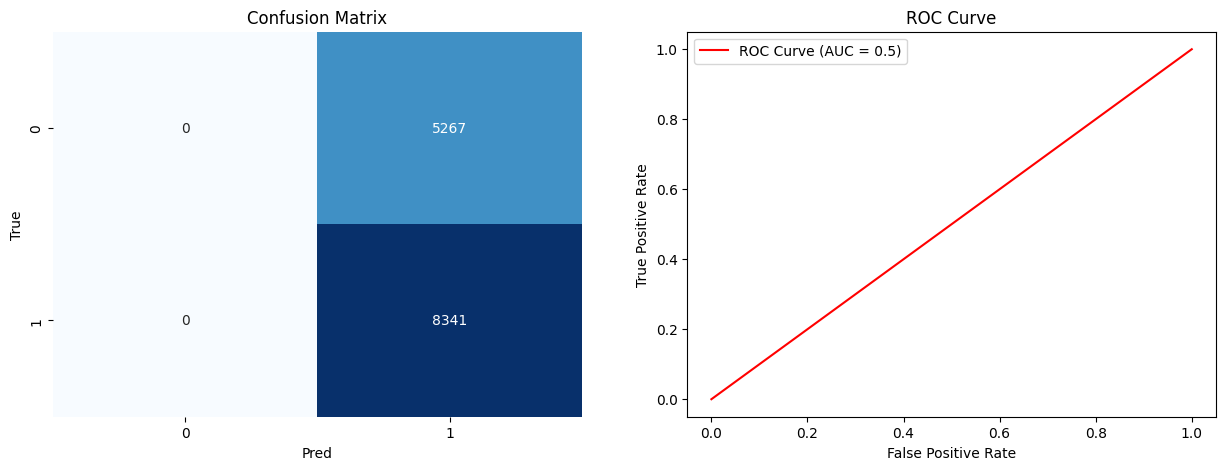

In [67]:
y_true = df_train["label"]
y_pred = np.array([majority_label for _ in range(len(df_train))])
y_pred_proba = np.array([[0, 1] for _ in range(len(df_train))])

evaluate(y_true, y_pred, y_pred_proba)

Accuracy: 0.6289673670093876

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       830
           1       0.63      1.00      0.77      1407

    accuracy                           0.63      2237
   macro avg       0.31      0.50      0.39      2237
weighted avg       0.40      0.63      0.49      2237



/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples

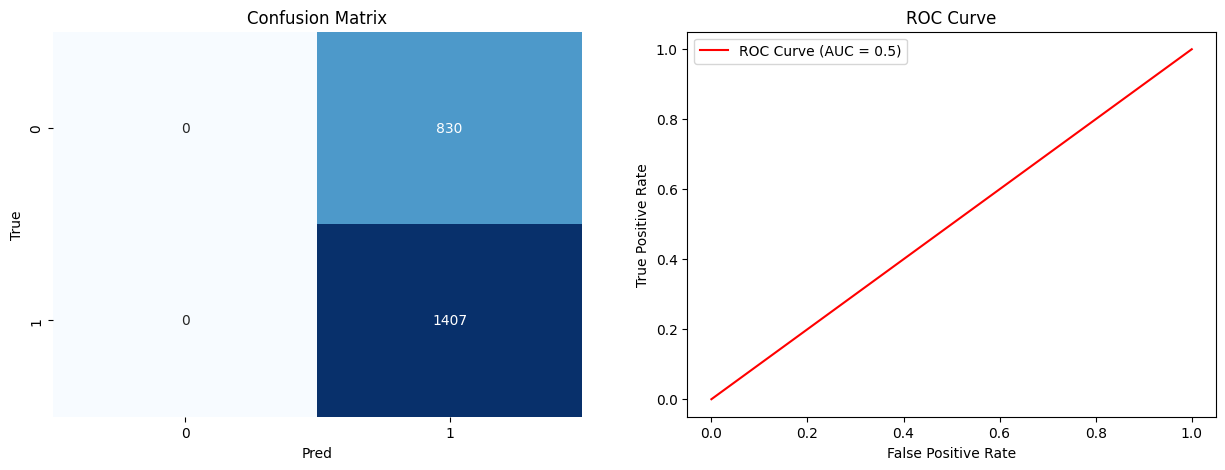

In [68]:
y_true = df_dev["label"]
y_pred = np.array([majority_label for _ in range(len(df_dev))])
y_pred_proba = np.array([[0, 1] for _ in range(len(df_dev))])

evaluate(y_true, y_pred, y_pred_proba)

## Strong Baseline

In [71]:
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

In [74]:
df_train_truncated = df_train.drop_duplicates(subset=["tweet_text"], ignore_index=True)
df_dev_truncated = df_dev.drop_duplicates(subset=["tweet_text"], ignore_index=True)

In [76]:
train_embeddings = sentence_transformer.encode(df_train_truncated["tweet_text"], device=device)

In [77]:
dev_embeddings = sentence_transformer.encode(df_dev_truncated["tweet_text"], device=device)

Accuracy: 0.8351174033149171

              precision    recall  f1-score   support

           0       0.78      0.59      0.67      3299
           1       0.85      0.93      0.89      8285

    accuracy                           0.84     11584
   macro avg       0.81      0.76      0.78     11584
weighted avg       0.83      0.84      0.83     11584



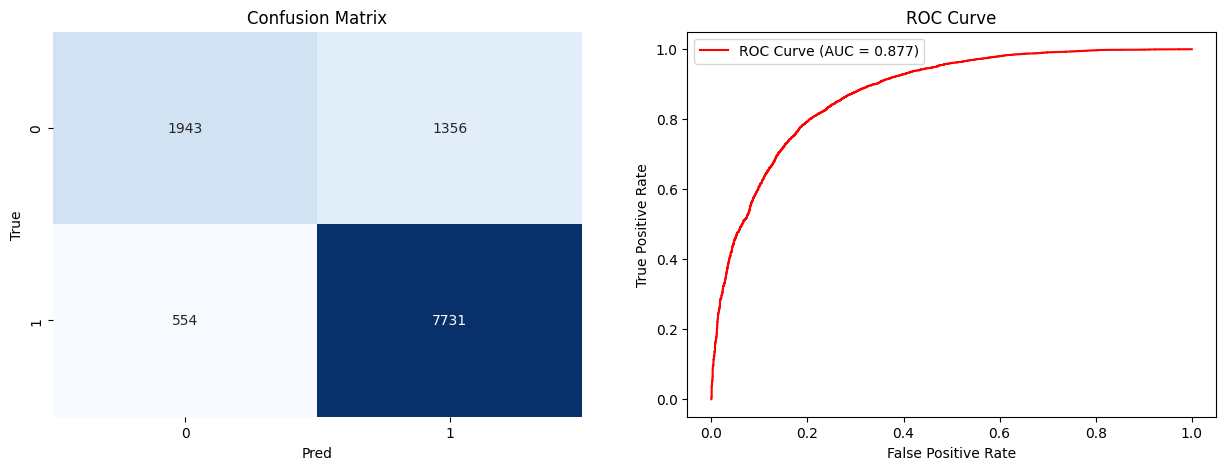

In [81]:
clf = LogisticRegression(random_state=42)
clf.fit(train_embeddings, df_train_truncated["label_text"])
y_pred = clf.predict(train_embeddings)
y_pred_proba = clf.predict_proba(train_embeddings)
evaluate(df_train_truncated["label_text"], y_pred, y_pred_proba)

Accuracy: 0.8211890925346446

              precision    recall  f1-score   support

           0       0.73      0.56      0.64       625
           1       0.85      0.92      0.88      1612

    accuracy                           0.82      2237
   macro avg       0.79      0.74      0.76      2237
weighted avg       0.81      0.82      0.81      2237



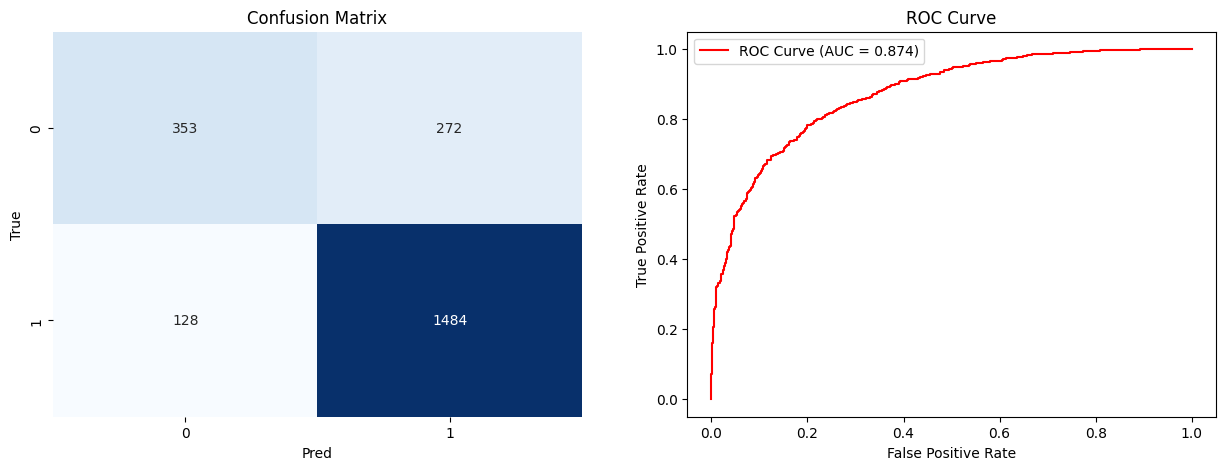

In [82]:
y_pred = clf.predict(dev_embeddings)
y_pred_proba = clf.predict_proba(dev_embeddings)
evaluate(df_dev_truncated["label_text"], y_pred, y_pred_proba)